In [115]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import config
from metrics import calc_metric

In [116]:
df = pd.read_csv('../../data/data_daily_with_aqi.csv')
target = 'AQI'
city ='北京'
df_tgt = df[df.type==target].drop('type',axis=1)
df_tgt_ct = df_tgt[['date',city]].rename(columns={'date':'ds',city:'y'})
df_tgt_ct = df_tgt_ct.dropna()
df_tgt_ct.set_index(pd.DatetimeIndex(df_tgt_ct['ds']),inplace=True)
df_tgt_ct = df_tgt_ct.drop('ds',axis=1).resample('M').mean()

In [117]:
y = df_tgt_ct.y[df_tgt_ct.index<'2022-01-01']

In [118]:
fraction = 0.7
y_train = df_tgt_ct.y[:int(len(y)*fraction)]
y_val = df_tgt_ct[int(len(y)*fraction):]

In [119]:
fit = SimpleExpSmoothing(y).fit(smoothing_level=0.8,optimized=False)

In [120]:
fit.summary()

Dep. Variable:,y,No. Observations:,84
Model:,SimpleExpSmoothing,SSE,62108.858
Optimized:,False,AIC,558.889
Trend:,None,BIC,563.751
Seasonal:,None,AICC,559.396
Seasonal Periods:,None,Date:,"Sat, 21 May 2022"
Box-Cox:,False,Time:,18:18:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000000,alpha,False
initial_level,165.30000,l.0,False


In [121]:
len(fit.fittedfcast) == len(y)+1

True

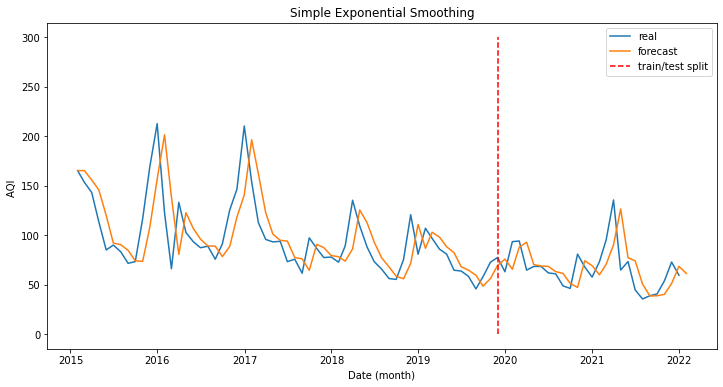

In [122]:
idx = y.index
idx = idx.append(pd.DatetimeIndex([pd.to_datetime('2022-01-31')]))
plt.figure(figsize=(12,6))
# plt.plot(pd.Series(fit.fittedfcast,index = idx[:len(fit.fittedfcast)]),label = 'forecast')
# plt.plot(pd.Series(y_train.values,index = idx[:len(y_train)]),label='train')
# plt.plot(y_val,label='validation')
# plt.plot(fit.forecast(len(y_val)),label='forecast of validation')
plt.plot(y,label='real')
plt.plot(pd.Series(fit.fittedfcast,index=idx),label = 'forecast')
plt.vlines(idx[len(y_train)],0,300, colors = "r", linestyles = "dashed",label='train/test split')
plt.xlabel('Date (month)')
plt.ylabel('AQI ')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.savefig('./pic/month/ses.png',facecolor='w')


In [123]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
def calc_metric(true,pred,model_name):
    res = {}
    res['MAE'] = mean_absolute_error(true,pred)
    res['MSE'] = mean_squared_error(true,pred)
    res['MAPE'] = mean_absolute_percentage_error(true,pred)
    res['r2'] = r2_score(true,pred)
    return pd.DataFrame(res,index=[model_name])

In [124]:
res1 = calc_metric(y_val,fit.forecast(len(y_val)),'Simple Exponential Smoothing')

In [125]:
fit2 = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True,damped_trend=True).fit(optimized=True)

In [126]:
fit2.summary()

Dep. Variable:,y,No. Observations:,58
Model:,ExponentialSmoothing,SSE,25926.858
Optimized:,True,AIC,387.950
Trend:,Additive,BIC,422.978
Seasonal:,Additive,AICC,407.950
Seasonal Periods:,12,Date:,"Sat, 21 May 2022"
Box-Cox:,True,Time:,18:18:40
Box-Cox Coeff.:,-0.56964,,
,coeff,code,optimized
smoothing_level,1.4902e-08,alpha,True
smoothing_trend,1.5549e-24,beta,True


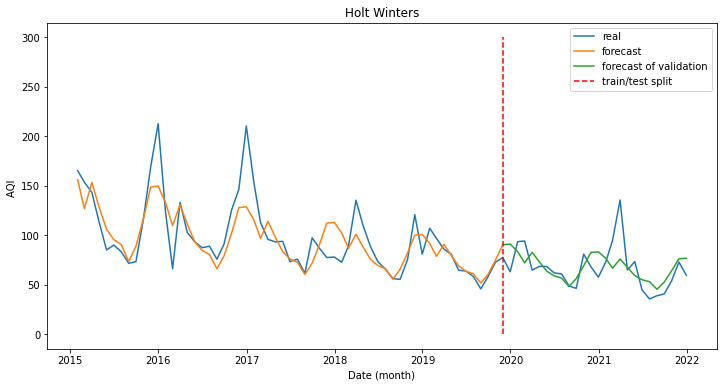

In [127]:
plt.figure(figsize=(12,6))
plt.plot(y,label='real')
plt.plot(pd.Series(fit2.fittedfcast,index=y.index[:len(fit2.fittedfcast)]),label = 'forecast')
plt.plot(fit2.forecast(len(y_val)-4),label='forecast of validation')
plt.vlines(idx[len(y_train)],0,300, colors = "r", linestyles = "dashed",label='train/test split')
plt.legend()
plt.xlabel('Date (month)')
plt.ylabel('AQI ')
plt.title('Holt Winters')
plt.legend()
plt.savefig('./pic/month/es.png',facecolor='w')

In [128]:
res1 = res1.append(calc_metric(y_val,fit2.forecast(len(y_val)),'Exponential Smoothing'))

/var/folders/l4/lww9t45j5qx1j3mc1k2mh6100000gn/T/ipykernel_7799/2606449886.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res1 = res1.append(calc_metric(y_val,fit2.forecast(len(y_val)),'Exponential Smoothing'))


In [129]:
fit3 = Holt(y, exponential=True, damped_trend=True).fit(optimized=True)

In [130]:
fit3.summary()

Dep. Variable:,y,No. Observations:,84
Model:,Holt,SSE,59084.988
Optimized:,True,AIC,560.697
Trend:,Multiplicative,BIC,572.851
Seasonal:,None,AICC,562.171
Seasonal Periods:,None,Date:,"Sat, 21 May 2022"
Box-Cox:,False,Time:,18:18:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9466870,alpha,True
smoothing_trend,0.0002793,beta,True


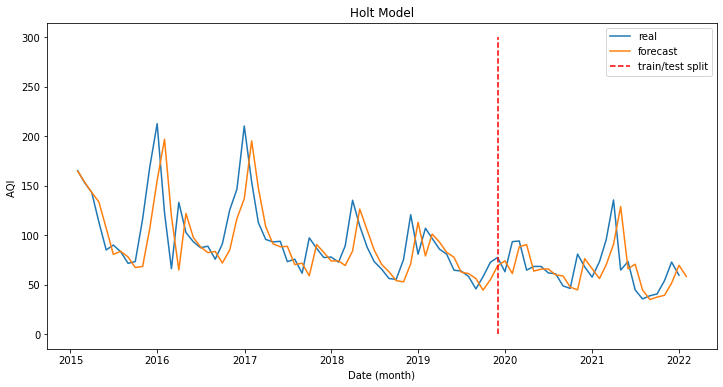

In [131]:
idx = y.index
idx = idx.append(pd.DatetimeIndex([pd.to_datetime('2022-01-31')]))
plt.figure(figsize=(12,6))
# plt.plot(pd.Series(fit.fittedfcast,index = idx[:len(fit.fittedfcast)]),label = 'forecast')
# plt.plot(pd.Series(y_train.values,index = idx[:len(y_train)]),label='train')
# plt.plot(y_val,label='validation')
# plt.plot(fit.forecast(len(y_val)),label='forecast of validation')
plt.plot(y,label='real')
plt.plot(pd.Series(fit3.fittedfcast,index=idx),label = 'forecast')
# plt.vlines(idx[len(y_train)],0,300, colors = "r", linestyles = "dashed",label='train/test split')
plt.vlines(idx[len(y_train)],0,300, colors = "r", linestyles = "dashed",label='train/test split')
plt.xlabel('Date (month)')
plt.ylabel('AQI ')
plt.title('Holt Model')
plt.legend()
plt.savefig('./pic/month/holt.png',facecolor='w')


In [132]:
fit3.params

{'smoothing_level': 0.9466870051428957,
 'smoothing_trend': 0.0002792720222470489,
 'smoothing_seasonal': nan,
 'damping_trend': 0.99013779471551,
 'initial_level': 176.9368779437577,
 'initial_trend': 0.9408592181410464,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [133]:
res1 = res1.append(calc_metric(y_val,fit3.forecast(len(y_val)),'Holt Model'))

/var/folders/l4/lww9t45j5qx1j3mc1k2mh6100000gn/T/ipykernel_7799/3603530855.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res1 = res1.append(calc_metric(y_val,fit3.forecast(len(y_val)),'Holt Model'))


In [134]:
res1

,MAE,MSE,MAPE,r2
Simple Exponential Smoothing,15.221641,439.232284,0.235097,-0.050295
Exponential Smoothing,13.162542,309.714662,0.203314,0.259409
Holt Model,23.177498,916.395024,0.309631,-1.191289


In [135]:
res1.to_csv('summary.csv')

In [136]:
res1

,MAE,MSE,MAPE,r2
Simple Exponential Smoothing,15.221641,439.232284,0.235097,-0.050295
Exponential Smoothing,13.162542,309.714662,0.203314,0.259409
Holt Model,23.177498,916.395024,0.309631,-1.191289
